# Imports

In [423]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np


In [424]:
df_teams=pd.read_csv('data_merged.csv')

# Feature selection

## Agregation and manual selection

In [425]:
# df_teams['GP'] = df_teams['GP'] + df_teams['PostGP']
# df_teams['GS'] = df_teams['GS'] + df_teams['PostGS']
# df_teams['minutes'] = df_teams['minutes'] + df_teams['PostMinutes']
# df_teams['points'] = df_teams['points'] + df_teams['PostPoints']
# df_teams['oRebounds'] = df_teams['oRebounds'] + df_teams['PostoRebounds']
# df_teams['dRebounds'] = df_teams['dRebounds'] + df_teams['PostdRebounds']
# df_teams['rebounds'] = df_teams['rebounds'] + df_teams['PostRebounds']
# df_teams['assists'] = df_teams['assists'] + df_teams['PostAssists']
# df_teams['steals'] = df_teams['steals'] + df_teams['PostSteals']
# df_teams['blocks'] = df_teams['blocks'] + df_teams['PostBlocks']
# df_teams['turnovers'] = df_teams['turnovers'] + df_teams['PostTurnovers']
# df_teams['PF'] = df_teams['PF'] + df_teams['PostPF']
# df_teams['fgAttempted'] = df_teams['fgAttempted'] + df_teams['PostfgAttempted']
# df_teams['fgMade'] = df_teams['fgMade'] + df_teams['PostfgMade']
# df_teams['ftAttempted'] = df_teams['ftAttempted'] + df_teams['PostftAttempted']
# df_teams['ftMade'] = df_teams['ftMade'] + df_teams['PostftMade']
# df_teams['threeAttempted'] = df_teams['threeAttempted'] + df_teams['PostthreeAttempted']
# df_teams['threeMade'] = df_teams['threeMade'] + df_teams['PostthreeMade']
# df_teams['dq'] = df_teams['dq'] + df_teams['PostDQ']

# df_teams.drop(columns=['PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostDQ'], inplace=True)


In [426]:
df_teams['performance'] = (df_teams['points'] + df_teams['rebounds'] +
                            df_teams['assists'] + df_teams['steals'] +
                            df_teams['blocks']) - (df_teams['turnovers'] +
                            df_teams['PF'])
df_teams['Postperformance'] = (df_teams['PostPoints'] + df_teams['PostRebounds'] +
                            df_teams['PostAssists'] + df_teams['PostSteals'] +
                            df_teams['PostBlocks']) - (df_teams['PostTurnovers'] +
                            df_teams['PostPF'])
                            
df_teams.drop(columns=['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF'], inplace=True)

In basketball, one can calculate the total points scored using the following formula:
Total Points = Free Throws Made (ftMade) + 2 * (Field Goals Made (fgMade) - Three-Pointers Made (threeMade)) + 3 * Three-Pointers Made (threeMade).
However, it's important to note that the given dataset already includes a dedicated column for total points. Consequently, the columns for Free Throws Made (ftMade), Field Goals Made (fgMade), and Three-Pointers Made (threeMade)  end up giving redundant information, and therefore, are not useful and can be deleted from the dataset.

In [427]:
points_made = 1 * df_teams['ftMade'] + 2 * (df_teams['fgMade'] - df_teams['threeMade']) + 3 * df_teams['threeMade']
points_attempted = 1 * df_teams['ftAttempted'] + 2 * (df_teams['fgAttempted'] - df_teams['threeAttempted']) + 3 * df_teams['threeAttempted']
df_teams['points_precision'] = points_attempted - points_made

post_points_made = 1 * df_teams['PostftMade'] + 2 * (df_teams['PostfgMade'] - df_teams['PostthreeMade']) + 3 * df_teams['PostthreeMade']
post_points_attempted = 1 * df_teams['PostftAttempted'] + 2 * (df_teams['PostfgAttempted'] - df_teams['PostthreeAttempted']) + 3 * df_teams['PostthreeAttempted']
df_teams['Postpoints_precision'] = post_points_attempted - post_points_made

df_teams.drop(columns=['ftMade', 'fgMade', 'threeMade', 'fgAttempted', 'ftAttempted', 'threeAttempted', 'PostftMade', 'PostfgMade', 'PostthreeMade', 'PostfgAttempted', 'PostftAttempted', 'PostthreeAttempted'], inplace=True)

The "won" and "lost" collumns is the sum of  "homeW","awayW", "homeL","awayL"


In [428]:
df_teams.drop(columns=["homeW","homeL","awayW","awayL"], inplace=True)

The rebound and postRebound are the sum of the offensive and defensive rebound. We can delete the offensive and defensive rebound columns.

In [429]:
df_teams.drop(columns=["oRebounds", "dRebounds", "PostoRebounds", "PostdRebounds"], inplace=True)

In [430]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     142 non-null    int64  
 1   tmID                     142 non-null    object 
 2   rank                     142 non-null    float64
 3   playoff                  142 non-null    int64  
 4   confW                    142 non-null    float64
 5   confL                    142 non-null    float64
 6   min                      142 non-null    float64
 7   attend                   142 non-null    float64
 8   num_playoff_appearances  142 non-null    float64
 9   mean_won                 142 non-null    float64
 10  mean_lost                142 non-null    float64
 11  confID_EA                142 non-null    float64
 12  confID_WE                142 non-null    float64
 13  GP                       142 non-null    float64
 14  GS                       1

Feature aggregationFrom the players we get the following statistics taht are repeated one for the normal season and one for the playoffs. To eliminate the redundancy we will sum the two columns and then delete the columns that are not needed.

## Function for bi-directional feature selection for each algorithm

In [431]:
def foward_selection(df, model, scaling=False):
    scaler=MinMaxScaler()
    if(scaling):
        X = scaler.fit_transform(df.drop(columns=['playoff']))
        X = pd.DataFrame(X, columns=df.drop(columns=['playoff']).columns)
    else:
        X = df.drop(columns=['playoff'])
    Y = df['playoff']
    ffs = SFS(model, k_features=(3, 32), forward=False, n_jobs=-1, cv=0)
    ffs.fit(X, Y)
    features = list(ffs.k_feature_names_)
    #if it does not have the 'playoff', 'year', 'tmID', 'confID_EA', 'confID_WE' add it
    if 'playoff' not in features:
        features.append('playoff')
    if 'year' not in features:
        features.append('year')
    if 'tmID' not in features:
        features.append('tmID')
    if 'confID_EA' not in features:
        features.append('confID_EA')
    if 'confID_WE' not in features:
        features.append('confID_WE')
    return features


In [432]:
from sklearn.feature_selection import SelectKBest, f_classif
def select_k_best(df):
    X=df.drop(['playoff'], axis=1)
    Y=df['playoff']
    fs = SelectKBest(score_func=f_classif, k=10)
    # apply feature selection
    X_selected = fs.fit_transform(X, Y)
    selected_feature_indices = fs.get_support()
    # Get the column names of the selected features
    selected_column_names = X.columns[selected_feature_indices]
    if 'playoff' not in selected_column_names:
        selected_column_names=selected_column_names.append(pd.Index(['playoff']))
    if 'year' not in selected_column_names:
        selected_column_names=selected_column_names.append(pd.Index(['year']))
    if 'tmID' not in selected_column_names:
        selected_column_names=selected_column_names.append(pd.Index(['tmID']))
    if 'confID_EA' not in selected_column_names:
        selected_column_names=selected_column_names.append(pd.Index(['confID_EA']))
    if 'confID_WE' not in selected_column_names:
        selected_column_names=selected_column_names.append(pd.Index(['confID_WE']))
    return selected_column_names
    

# Train and test

## Functions

In [433]:
def split_data(df):
    # Filter the rows based on the 'confID_EA' and 'confID_EW' values
    confEA_data = df[df['confID_EA'] == 1]
    confEW_data = df[df['confID_WE'] == 1]

    return confEA_data, confEW_data
    

In [434]:
df_teams = df_teams[df_teams['year'] != 1]
#use label encoder to convert categorical data to numerical data of tmID column
le = LabelEncoder()
df_teams['tmID'] = le.fit_transform(df_teams['tmID'])


df_teams.head()


,year,tmID,rank,playoff,confW,confL,min,attend,num_playoff_appearances,mean_won,...,award_count_x,won,lost,post_wins,post_losses,award_count_y,performance,Postperformance,points_precision,Postpoints_precision
16,2,1,8.0,1,5.0,16.0,6475.0,90963.0,0.0,8.0,...,0.000000,9.0,23.0,0.0,0.0,0.0,279.111111,6.777778,271.111111,10.000000
17,2,3,2.0,1,13.0,8.0,6500.0,137532.0,1.0,17.0,...,0.000000,17.0,15.0,3.0,3.0,0.0,206.769231,37.769231,178.076923,32.000000
18,2,5,5.0,0,10.0,11.0,6425.0,107289.0,0.0,14.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,326.285714,0.000000,279.000000,0.000000
19,2,6,2.0,1,17.0,4.0,6475.0,196077.0,1.0,27.0,...,0.142857,27.0,5.0,6.0,0.0,0.0,224.000000,39.142857,161.714286,28.285714
20,2,7,7.0,0,7.0,14.0,6425.0,180270.0,0.0,9.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,269.300000,3.500000,259.000000,3.300000


No need to sample the data, as it is balanced.

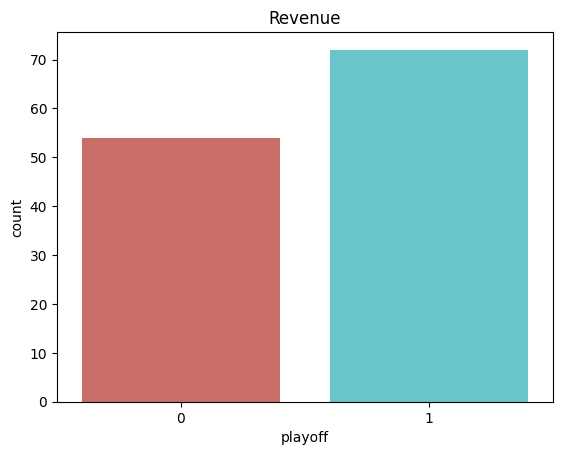

In [435]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [436]:
from sklearn.decomposition import PCA
from sklearn import metrics

def split_and_train(year, model, data, target_col="playoff", scaling=False):
        # Split the data into training and test sets
        train_data = data[data["year"] < year ]
        test_data = data[data["year"] == year ]


        if(scaling):
            scaler = MinMaxScaler()
            train_data = scaler.fit_transform(train_data)
            train_data = pd.DataFrame(train_data, columns=data.columns)
            test_data = scaler.transform(test_data)
            test_data = pd.DataFrame(test_data, columns=data.columns)


        X_train = train_data.drop([target_col], axis=1)
        y_train = train_data[target_col]
        X_test = test_data.drop([target_col], axis=1)
        y_test = test_data[target_col]

        #PCA
        # pca = PCA(n_components=28, svd_solver='full')
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        # Create and train the decision tree model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        #y_pred = model.predict(X_test)
        # Make probability predictions on the test set
        # Sort the probabilities in reverse order and get the indices
        y_prob = model.predict_proba(X_test)
        sorted_indices = np.argsort(-y_prob[:, 1])

        # Set the top 4 predictions with target 1 and others with target 0
        y_pred = np.zeros_like(y_test)
        y_pred[sorted_indices[:4]] = 1
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob[:, 1]})


        return y_test, y_pred, y_prob[:, 1]
        


def train_evaluate_decision_tree_graph(model, data, target_col="playoff", scaling=False):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    years_tested = []

    # Sort the data by the "year" column
    data = data.sort_values(by="year")
    data1, data2 = split_data(data)
    years = sorted(data["year"].unique())

    for year in years[3:]:
       
        y_test1, y_pred1, y_prob1 = split_and_train(year, model, data1, target_col, scaling)
        y_test2, y_pred2, y_prob2 = split_and_train(year, model, data2, target_col, scaling)
        # Merge of 
        # Join y_test1 and y_test2
        y_test = np.concatenate([y_test1, y_test2])

        # Join y_pred1 and y_pred2
        y_pred = np.concatenate([y_pred1, y_pred2])
        
        y_prob = np.concatenate([y_prob1, y_prob2])
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob})

        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        years_tested.append(year)

        # confusion matrix
        # confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=['0', '1']).plot()
        # cm_display.plot()
        # plt.show()
        

    return years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores


In [440]:
def plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores):
    # Create a graph to plot accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(20, 5))

    # Plot accuracy
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores, marker='o')
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot precision
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores, marker='o', color='orange')
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot recall
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores, marker='o', color='green')
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot f1
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores, marker='o', color='red')
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    plt.tight_layout()
    plt.show()
    
    # Calculate means
    accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)
    precision_mean = sum(precision_scores) / len(precision_scores)
    recall_mean = sum(recall_scores) / len(recall_scores)
    f1_mean = sum(f1_scores) / len(f1_scores)

    print("Accuracy: ", accuracy_mean)
    print("Precision: ", precision_mean)
    print("Recall: ", recall_mean)
    print("F1: ", f1_mean)


def plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores,
                          bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores,
                          kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores):
    # Define colors for the three training methods
    normal_color = 'blue'
    bidirectional_color = 'red'
    kbest_color = 'green'

    # Create separate plots for accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(25, 5))

    # Create a small noise factor to offset the lines
    noise_factor = 0.01  # Adjust this value as needed

    # Plot accuracy for the three training methods with noise
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Normal Training', color=normal_color)
    plt.plot(years_tested, bidirectional_accuracy_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Directional Selection', color=bidirectional_color)
    plt.plot(years_tested, kbest_accuracy_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='KBest Selection', color=kbest_color)
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.2)  # Set the y-limits between 0.5 and 1
        
    # Plot precision for the three training methods with noise
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Normal Training', color=normal_color)
    plt.plot(years_tested, bidirectional_precision_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Directional Selection', color=bidirectional_color)
    plt.plot(years_tested, kbest_precision_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='KBest Selection', color=kbest_color)
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')
    plt.ylim(0, 1.2)  # Set the y-limits between 0.5 and 1

    # Plot recall for the three training methods with noise
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Normal Training', color=normal_color)
    plt.plot(years_tested, bidirectional_recall_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Directional Selection', color=bidirectional_color)
    plt.plot(years_tested, kbest_recall_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='KBest Selection', color=kbest_color)
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')
    plt.ylim(0, 1.2)  # Set the y-limits between 0.5 and 1

    # Plot F1 for the three training methods with noise
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Normal Training', color=normal_color)
    plt.plot(years_tested, bidirectional_f1_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='Directional Selection', color=bidirectional_color)
    plt.plot(years_tested, kbest_f1_scores + np.random.rand(len(years_tested)) * noise_factor, marker='o', label='KBest Selection', color=kbest_color)
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place the legend outside the plot
    plt.ylim(0, 1.2)  # Set the y-limits between 0.5 and 1

    plt.tight_layout()
    plt.show()
    
    print("Normal Training")
    print("Accuracy: {:.2f}".format(sum(accuracy_scores) / len(accuracy_scores)), end=", ")
    print("Precision: {:.2f}".format(sum(precision_scores) / len(precision_scores)), end=", ")
    print("Recall: {:.2f}".format(sum(recall_scores) / len(recall_scores)), end=", ")
    print("F1: {:.2f}".format(sum(f1_scores) / len(f1_scores)))

    print("10 year")
    print("Accuracy:", accuracy_scores[-1], end=", ")
    print("Precision:", precision_scores[-1], end=", ")
    print("Recall:", recall_scores[-1], end=", ")
    print("F1:", f1_scores[-1])

    print("Directional Selection")
    print("Accuracy: {:.2f}".format(sum(bidirectional_accuracy_scores) / len(bidirectional_accuracy_scores)), end=", ")
    print("Precision: {:.2f}".format(sum(bidirectional_precision_scores) / len(bidirectional_precision_scores)), end=", ")
    print("Recall: {:.2f}".format(sum(bidirectional_recall_scores) / len(bidirectional_recall_scores)), end=", ")
    print("F1: {:.2f}".format(sum(bidirectional_f1_scores) / len(bidirectional_f1_scores)))

    print("10 year")
    print("Accuracy:", bidirectional_accuracy_scores[-1], end=", ")
    print("Precision:", bidirectional_precision_scores[-1], end=", ")
    print("Recall:", bidirectional_recall_scores[-1], end=", ")
    print("F1:", bidirectional_f1_scores[-1])

    print("KBest Selection")
    print("Accuracy: {:.2f}".format(sum(kbest_accuracy_scores) / len(kbest_accuracy_scores)), end=", ")
    print("Precision: {:.2f}".format(sum(kbest_precision_scores) / len(kbest_precision_scores)), end=", ")
    print("Recall: {:.2f}".format(sum(kbest_recall_scores) / len(kbest_recall_scores)), end=", ")
    print("F1: {:.2f}".format(sum(kbest_f1_scores) / len(kbest_f1_scores)))

    print("10 year")
    print("Accuracy:", kbest_accuracy_scores[-1], end=", ")
    print("Precision:", kbest_precision_scores[-1], end=", ")
    print("Recall:", kbest_recall_scores[-1], end=", ")
    print("F1:", kbest_f1_scores[-1])


    

## Models

In [ ]:
df_teams_kbest  = df_teams[select_k_best(df_teams)]
df_teams_kbest.head()

,confW,mean_won,minutes,PostGP,PostGS,PostMinutes,post_wins,performance,Postperformance,Postpoints_precision,playoff,year,tmID,confID_EA,confID_WE
16,5.0,8.0,636.555556,1.333333,0.444444,20.222222,0.0,279.111111,6.777778,10.000000,1,2,1,1.0,0.0
17,13.0,17.0,483.153846,4.384615,1.846154,81.384615,3.0,206.769231,37.769231,32.000000,1,2,3,1.0,0.0
18,10.0,14.0,688.571429,0.000000,0.000000,0.000000,0.0,326.285714,0.000000,0.000000,0,2,5,1.0,0.0
19,17.0,27.0,507.428571,4.428571,2.571429,108.285714,6.0,224.000000,39.142857,28.285714,1,2,6,0.0,1.0
20,7.0,9.0,621.900000,0.600000,0.100000,6.900000,0.0,269.300000,3.500000,3.300000,0,2,7,1.0,0.0


### Desicion Tree

#### Hyperparameter tuning

In [ ]:
from  sklearn.model_selection import GridSearchCV

# model = DecisionTreeClassifier()
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4, 5 ],
#                 'criterion': ['gini', 'entropy', 'log_loss'],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'splitter': ['best', 'random'],
                
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_)
# DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4, min_samples_split=4, splitter='random')


KeyboardInterrupt: 

['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'lost', 'post_wins', 'post_losses', 'award_count_y', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'playoff']


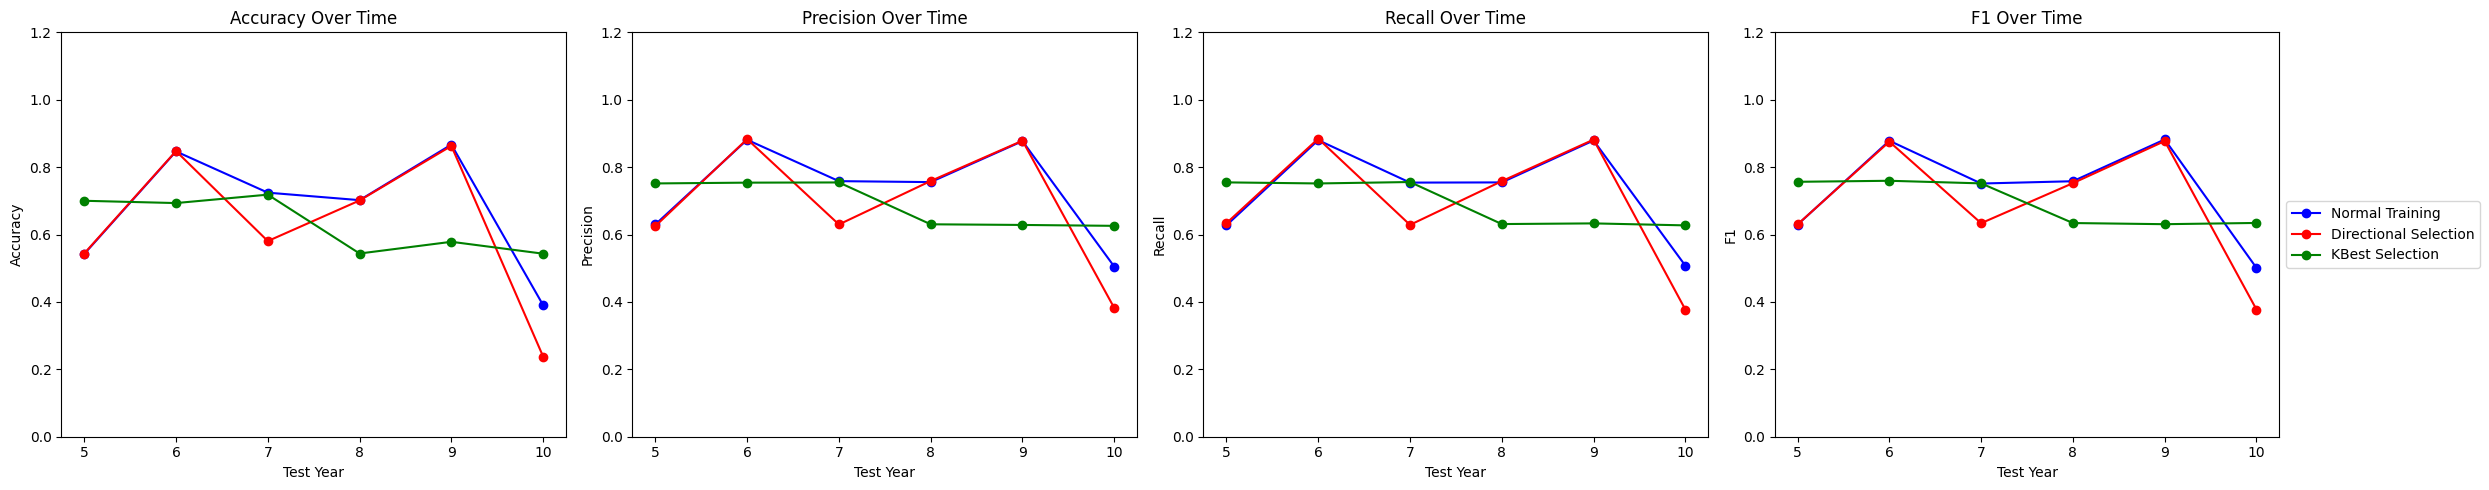

Normal Training
Accuracy: 0.67, Precision: 0.73, Recall: 0.73, F1: 0.73
10 year
Accuracy: 0.38461538461538464, Precision: 0.5, Recall: 0.5, F1: 0.5
Directional Selection
Accuracy: 0.62, Precision: 0.69, Recall: 0.69, F1: 0.69
10 year
Accuracy: 0.23076923076923078, Precision: 0.375, Recall: 0.375, F1: 0.375
KBest Selection
Accuracy: 0.62, Precision: 0.69, Recall: 0.69, F1: 0.69
10 year
Accuracy: 0.5384615384615384, Precision: 0.625, Recall: 0.625, F1: 0.625


In [442]:
features = foward_selection(df_teams, DecisionTreeClassifier())
print(features)
model = DecisionTreeClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### Random Forest

#### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# model = RandomForestClassifier()

# param_grid = {'max_depth': [4, 6, 10, 100, 200, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4 ],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'max_leaf_nodes': [None,  6, 7, 10, 20],
#                 'min_impurity_decrease': [0, 0.1, 0.2],
#                 'bootstrap': [False, True],
#                 'class_weight': ['balanced', 'balanced_subsample', None],
#                 'n_jobs': [None, 2, 3],                
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)


In [ ]:
# RandomForestClassifier(bootstrap=False, max_depth=200, max_features='log2', min_impurity_decrease=0.2, n_jobs=2) 0.8975384615384616
# RandomForestClassifier(bootstrap=False, max_depth=200, max_features='log2',
                    #    max_leaf_nodes=6, min_impurity_decrease=0.2,
                    #    min_samples_split=6, n_jobs=3)


['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'lost', 'post_wins', 'post_losses', 'award_count_y', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'playoff']


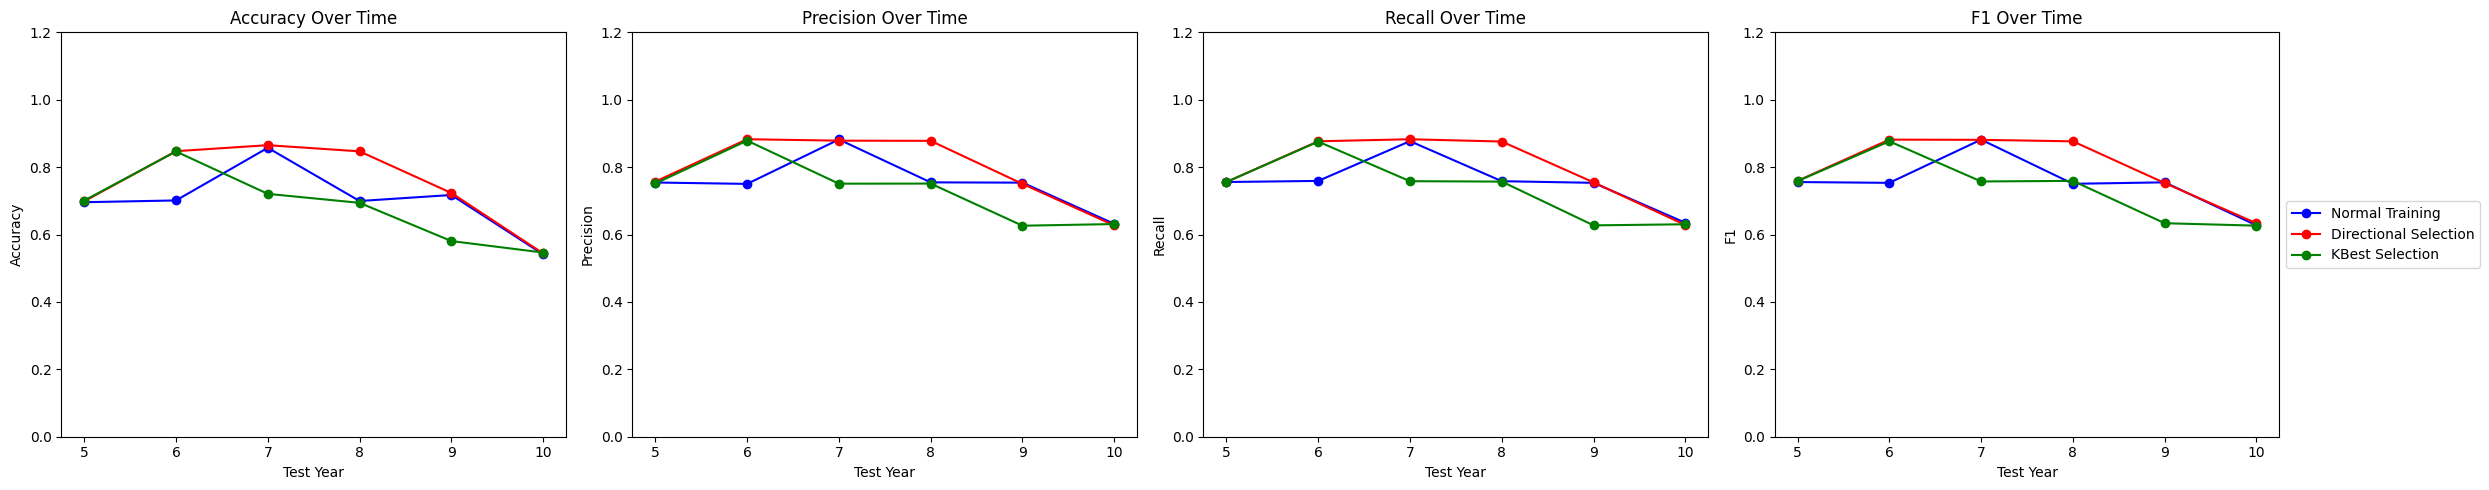

Normal Training
Accuracy:  0.6978021978021979
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.6923076923076923, 0.8571428571428571, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.75, 0.75, 0.875, 0.75, 0.75]
Recall:  [0.75, 0.75, 0.875, 0.75, 0.75]
F1:  [0.75, 0.75, 0.875, 0.75, 0.75]
Directional Selection
Accuracy:  0.7490842490842491
Precision:  0.7916666666666666
Recall:  0.7916666666666666
F1:  0.7916666666666666
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.8571428571428571, 0.8461538461538461, 0.7142857142857143]
Precision:  [0.75, 0.875, 0.875, 0.875, 0.75]
Recall:  [0.75, 0.875, 0.875, 0.875, 0.75]
F1:  [0.75, 0.875, 0.875, 0.875, 0.75]
KBest Selection
Accuracy:  0.6758241758241758
Precision:  0.7291666666666666
Recall:  0.7291666666666666
F1:  0.7291666666666666
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.6923076923076923, 0.5714285714285714]
Precision:  [0.75, 0.875, 0.75, 0.75, 0

In [ ]:
features = foward_selection(df_teams, RandomForestClassifier())
print(features)
model=RandomForestClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### KNN

#### Hyperparameter tuning

In [ ]:

# model = KNeighborsClassifier()

# param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'leaf_size': [5, 10, 20, 30, 40, 50],
#               'p': [1, 2, 3],
#               'metric': ['minkowski', 'euclidean', 'manhattan']          
#               }
# grid = GridSearchCV(model, param_grid)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# X = pd.DataFrame(X, columns=df_teams.drop(columns=['playoff']).columns)
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)




['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'GP', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'post_wins', 'performance', 'Postperformance', 'points_precision', 'playoff', 'confID_WE']


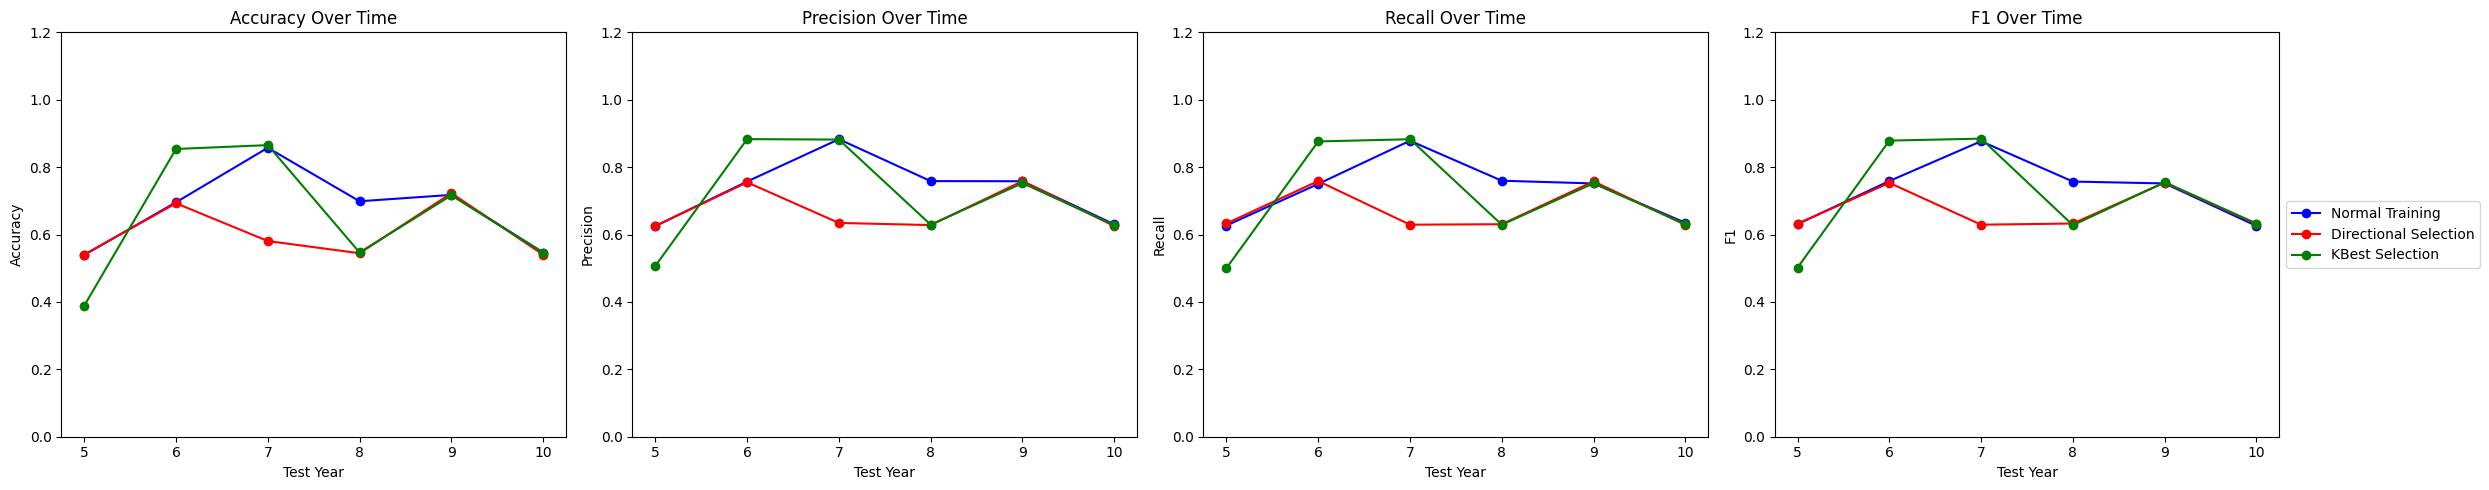

Normal Training
Accuracy:  0.6721611721611721
Precision:  0.7291666666666666
Recall:  0.7291666666666666
F1:  0.7291666666666666
10 year
Accuracy:  [0.5384615384615384, 0.6923076923076923, 0.8571428571428571, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.625, 0.75, 0.875, 0.75, 0.75]
Recall:  [0.625, 0.75, 0.875, 0.75, 0.75]
F1:  [0.625, 0.75, 0.875, 0.75, 0.75]
Directional Selection
Accuracy:  0.5989010989010989
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1:  0.6666666666666666
10 year
Accuracy:  [0.5384615384615384, 0.6923076923076923, 0.5714285714285714, 0.5384615384615384, 0.7142857142857143]
Precision:  [0.625, 0.75, 0.625, 0.625, 0.75]
Recall:  [0.625, 0.75, 0.625, 0.625, 0.75]
F1:  [0.625, 0.75, 0.625, 0.625, 0.75]
KBest Selection
Accuracy:  0.6465201465201466
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.38461538461538464, 0.8461538461538461, 0.8571428571428571, 0.5384615384615384, 0.71428571428

In [ ]:
features = foward_selection(df_teams, KNeighborsClassifier(), scaling=True)
print(features)
model = KNeighborsClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### XGBoost

#### Hyperparameter tuning

In [ ]:

# model = XGBClassifier()

# param_grid = {'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2, 5],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [3, 4, 5],
#               'n_estimators': [100, 200, 300],
#               'learning_rate': [0.01, 0.1, 0.2],     
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)

# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)
# #XGBClassifier(colsample_bytree=1.0, gamma=5, learning_rate=0.01,max_depth=3, min_child_weight=10,  n_estimators=100) 0.8898461538461537


['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'lost', 'post_wins', 'post_losses', 'award_count_y', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'playoff']


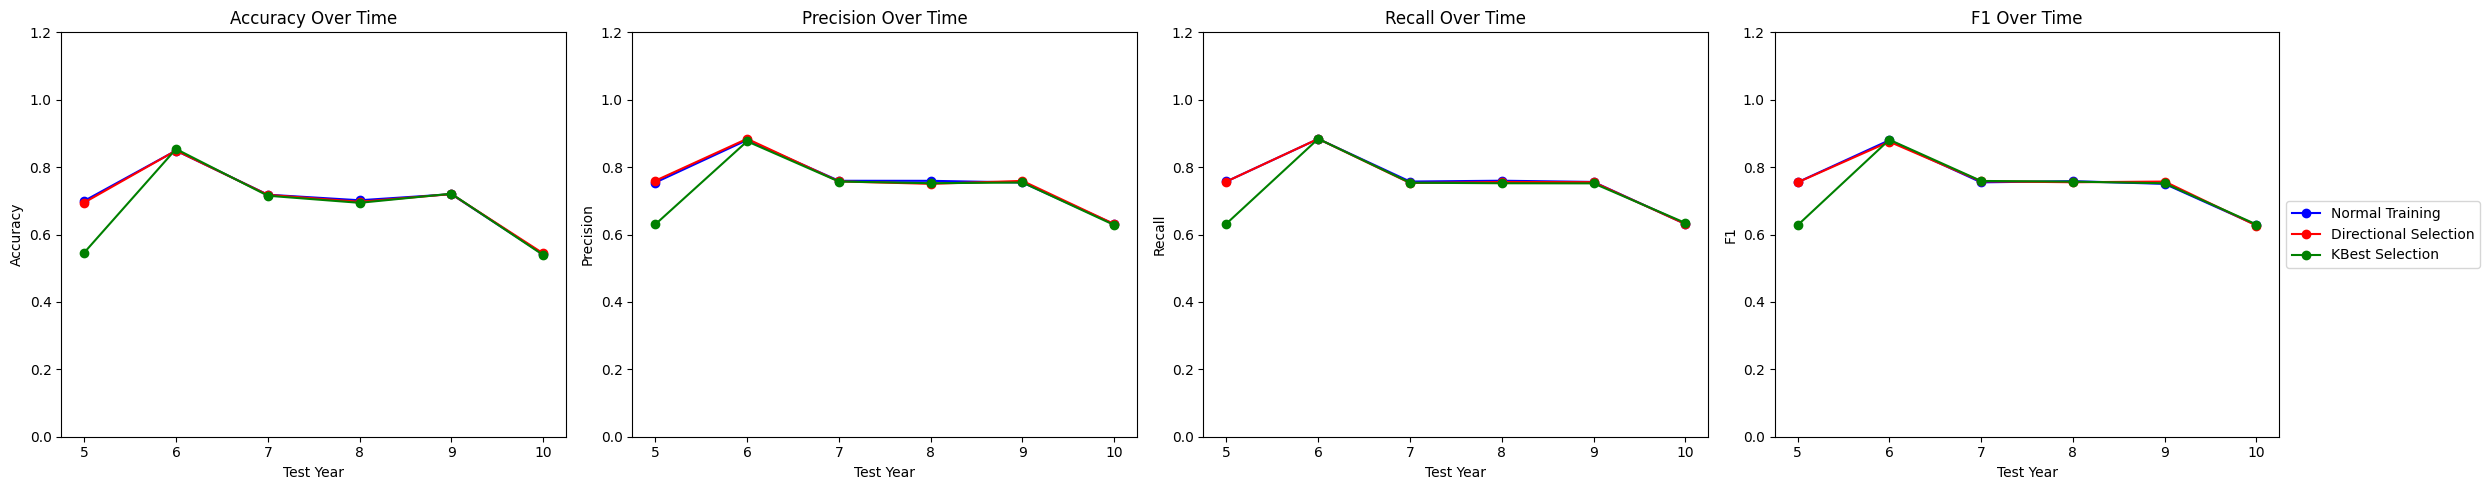

Normal Training
Accuracy:  0.6996336996336997
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.75, 0.875, 0.75, 0.75, 0.75]
Recall:  [0.75, 0.875, 0.75, 0.75, 0.75]
F1:  [0.75, 0.875, 0.75, 0.75, 0.75]
Directional Selection
Accuracy:  0.6996336996336997
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.75, 0.875, 0.75, 0.75, 0.75]
Recall:  [0.75, 0.875, 0.75, 0.75, 0.75]
F1:  [0.75, 0.875, 0.75, 0.75, 0.75]
KBest Selection
Accuracy:  0.6739926739926739
Precision:  0.7291666666666666
Recall:  0.7291666666666666
F1:  0.7291666666666666
10 year
Accuracy:  [0.5384615384615384, 0.8461538461538461, 0.7142857142857143, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.625, 0.875, 0.75, 0.75, 0.75]
Recall:  [0.625, 0.875, 0.75, 0.75, 0.75]


In [ ]:
features = foward_selection(df_teams, XGBClassifier())
print(features)
model = XGBClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### Naive bayes

#### Hyperparameter tuning

In [ ]:

# model = GaussianNB()

# param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
#               'priors': [None, [0.5, 0.5], [0.6, 0.4], [0.4, 0.6], [0.7, 0.3], [0.3, 0.7], [0.8, 0.2], [0.2, 0.8], [0.9, 0.1], [0.1, 0.9]]
#                   }

              
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
#X = pd.DataFrame(X, columns=df_teams.drop(columns=['playoff']).columns)
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)




['year', 'tmID', 'confW', 'confL', 'min', 'attend', 'mean_won', 'PostMinutes', 'won', 'post_wins', 'performance', 'Postperformance', 'playoff', 'confID_EA', 'confID_WE']


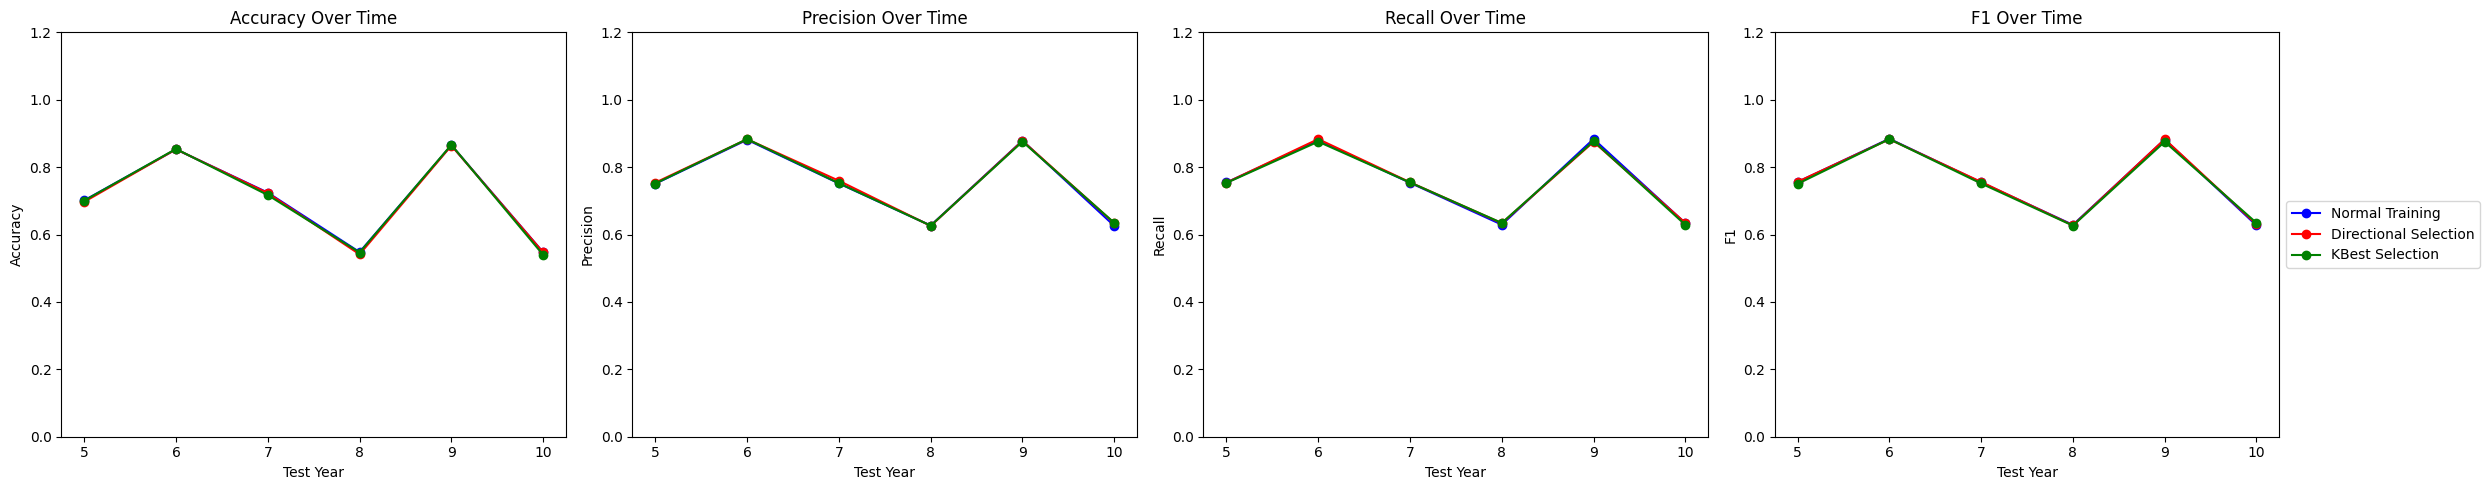

Normal Training
Accuracy:  0.6978021978021979
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.5384615384615384, 0.8571428571428571]
Precision:  [0.75, 0.875, 0.75, 0.625, 0.875]
Recall:  [0.75, 0.875, 0.75, 0.625, 0.875]
F1:  [0.75, 0.875, 0.75, 0.625, 0.875]
Directional Selection
Accuracy:  0.6978021978021979
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.5384615384615384, 0.8571428571428571]
Precision:  [0.75, 0.875, 0.75, 0.625, 0.875]
Recall:  [0.75, 0.875, 0.75, 0.625, 0.875]
F1:  [0.75, 0.875, 0.75, 0.625, 0.875]
KBest Selection
Accuracy:  0.6978021978021979
Precision:  0.75
Recall:  0.75
F1:  0.75
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.5384615384615384, 0.8571428571428571]
Precision:  [0.75, 0.875, 0.75, 0.625, 0.875]
Recall:  [0.75, 0.875, 0.75, 0.625, 0.875]
F1:  [0.75, 0.875, 0.75, 0.6

In [ ]:
features = foward_selection(df_teams, GaussianNB())
print(features)
model = GaussianNB()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### SVC

#### Hyperparameter tuning

In [ ]:

# model = SVC()
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                 'degree': [1, 2, 3, 4, 5, 6],
#                 'gamma': [1,0.1,0.001,0.0001,'scale', 'auto'],
                    
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# X = pd.DataFrame(X, columns=df_teams.drop(columns=['playoff']).columns)
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)



['tmID', 'rank', 'confW', 'confL', 'num_playoff_appearances', 'confID_EA', 'minutes', 'dq', 'PostDQ', 'height', 'weight', 'lost', 'post_wins', 'points_precision', 'playoff', 'year', 'confID_WE']


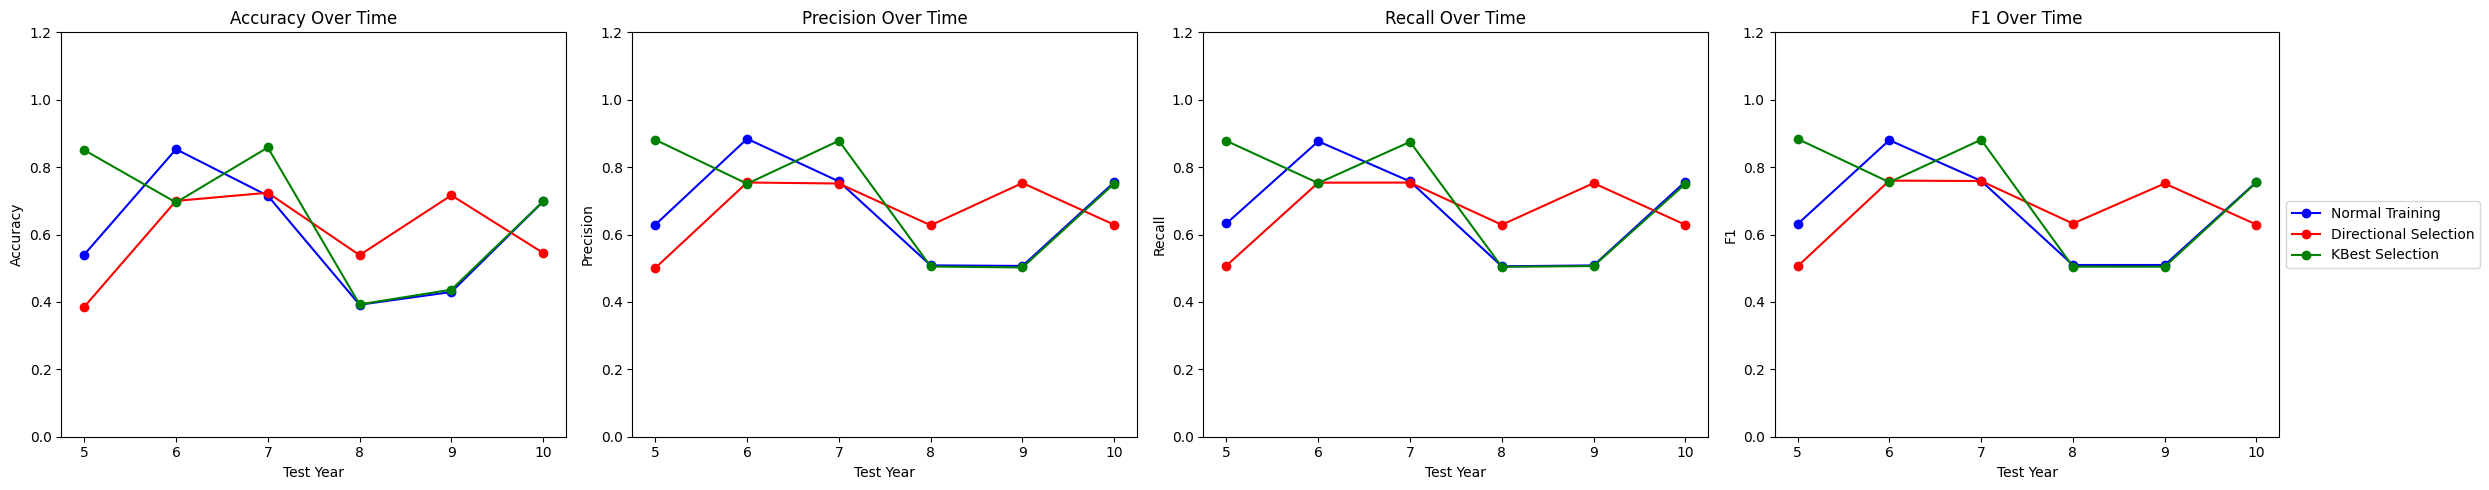

Normal Training
Accuracy:  0.6007326007326007
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1:  0.6666666666666666
10 year
Accuracy:  [0.5384615384615384, 0.8461538461538461, 0.7142857142857143, 0.38461538461538464, 0.42857142857142855]
Precision:  [0.625, 0.875, 0.75, 0.5, 0.5]
Recall:  [0.625, 0.875, 0.75, 0.5, 0.5]
F1:  [0.625, 0.875, 0.75, 0.5, 0.5]
Directional Selection
Accuracy:  0.5970695970695971
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1:  0.6666666666666666
10 year
Accuracy:  [0.38461538461538464, 0.6923076923076923, 0.7142857142857143, 0.5384615384615384, 0.7142857142857143]
Precision:  [0.5, 0.75, 0.75, 0.625, 0.75]
Recall:  [0.5, 0.75, 0.75, 0.625, 0.75]
F1:  [0.5, 0.75, 0.75, 0.625, 0.75]
KBest Selection
Accuracy:  0.6501831501831501
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.8461538461538461, 0.6923076923076923, 0.8571428571428571, 0.38461538461538464, 0.42857142857142855]
Prec

In [ ]:
features = foward_selection(df_teams,SVC(), scaling=True )
print(features)
model =SVC(probability=True)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### Logistic regression

#### Hyperparameter tuning

In [ ]:

# model = LogisticRegression()
# param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
#                 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#                 'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
#                 'max_iter': [100, 200, 300, 400, 500],
#                 'multi_class': ['auto', 'ovr', 'multinomial'],
#                 'class_weight': ['balanced', None],
                    
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# X = pd.DataFrame(X, columns=df_teams.drop(columns=['playoff']).columns)
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)

# # LogisticRegression(C=10, class_weight='balanced', penalty='l1', solver='saga') 0.8975384615384616


['tmID', 'confL', 'mean_won', 'GS', 'minutes', 'PostGP', 'height', 'lost', 'post_wins', 'playoff', 'year', 'confID_EA', 'confID_WE']


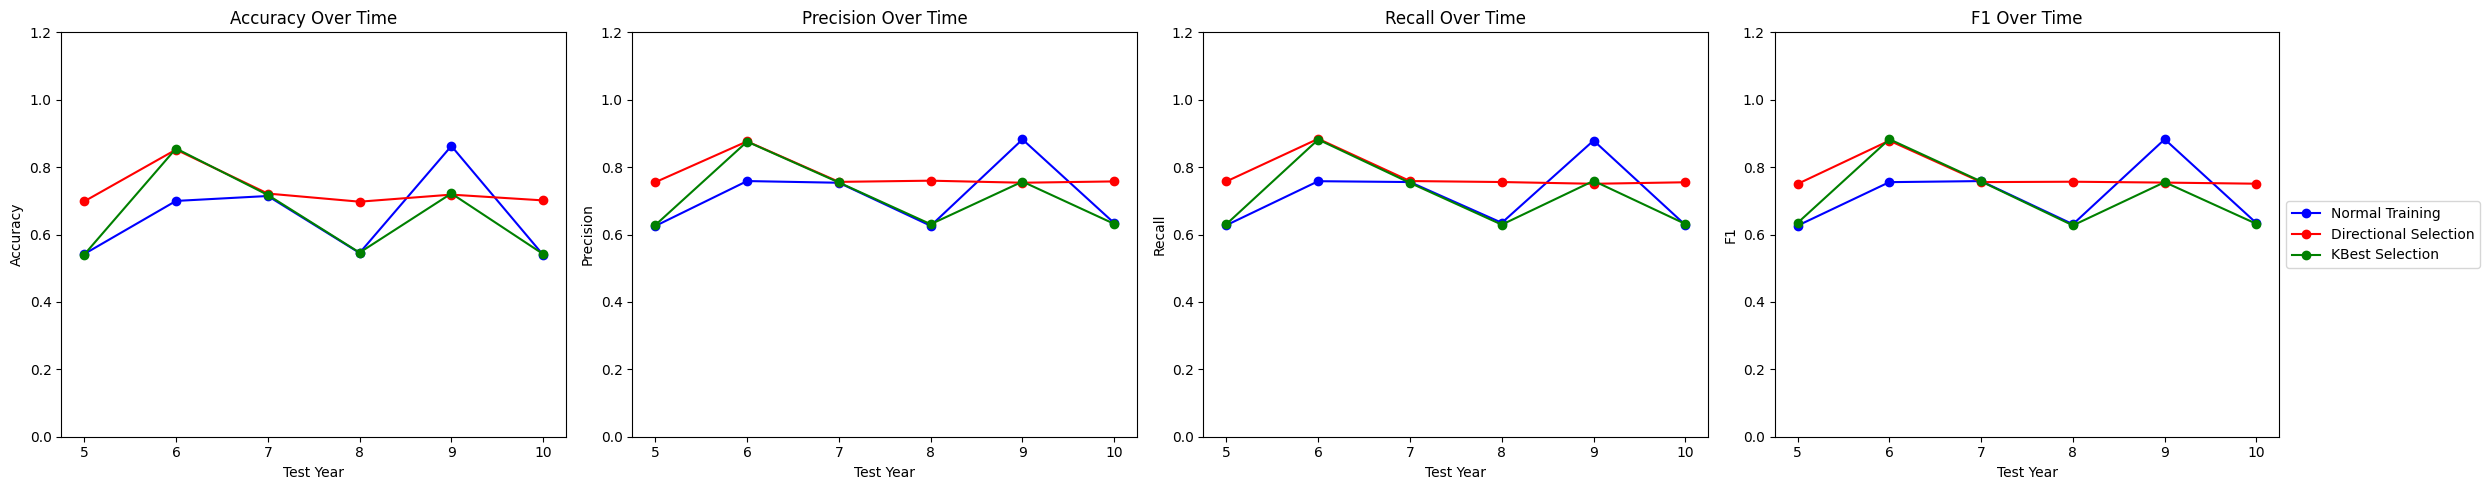

Normal Training
Accuracy:  0.6465201465201466
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.5384615384615384, 0.6923076923076923, 0.7142857142857143, 0.5384615384615384, 0.8571428571428571]
Precision:  [0.625, 0.75, 0.75, 0.625, 0.875]
Recall:  [0.625, 0.75, 0.75, 0.625, 0.875]
F1:  [0.625, 0.75, 0.75, 0.625, 0.875]
Directional Selection
Accuracy:  0.7252747252747254
Precision:  0.7708333333333334
Recall:  0.7708333333333334
F1:  0.7708333333333334
10 year
Accuracy:  [0.6923076923076923, 0.8461538461538461, 0.7142857142857143, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.75, 0.875, 0.75, 0.75, 0.75]
Recall:  [0.75, 0.875, 0.75, 0.75, 0.75]
F1:  [0.75, 0.875, 0.75, 0.75, 0.75]
KBest Selection
Accuracy:  0.6483516483516484
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.5384615384615384, 0.8461538461538461, 0.7142857142857143, 0.5384615384615384, 0.714285714285714

In [ ]:
features = foward_selection(df_teams, LogisticRegression(), scaling=True)
print(features)
model = LogisticRegression()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)

### MPL

#### Hyperparameter tuning

In [ ]:

# model = MLPClassifier()
# param_grid = {
#     'hidden_layer_sizes': [(10,30,10),(20,), (50, 50), (100, 100), (100, 50, 25)],
#     'activation': ['tanh', 'relu', 'logistic', 'identity'],
#     'solver': ['sgd', 'adam', 'lbfgs'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant','adaptive'],
# }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# X = pd.DataFrame(X, columns=df_teams.drop(columns=['playoff']).columns)
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)

# MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 30, 10),
#               learning_rate='adaptive', solver='lbfgs')


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'post_wins', 'award_count_y', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'playoff']


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

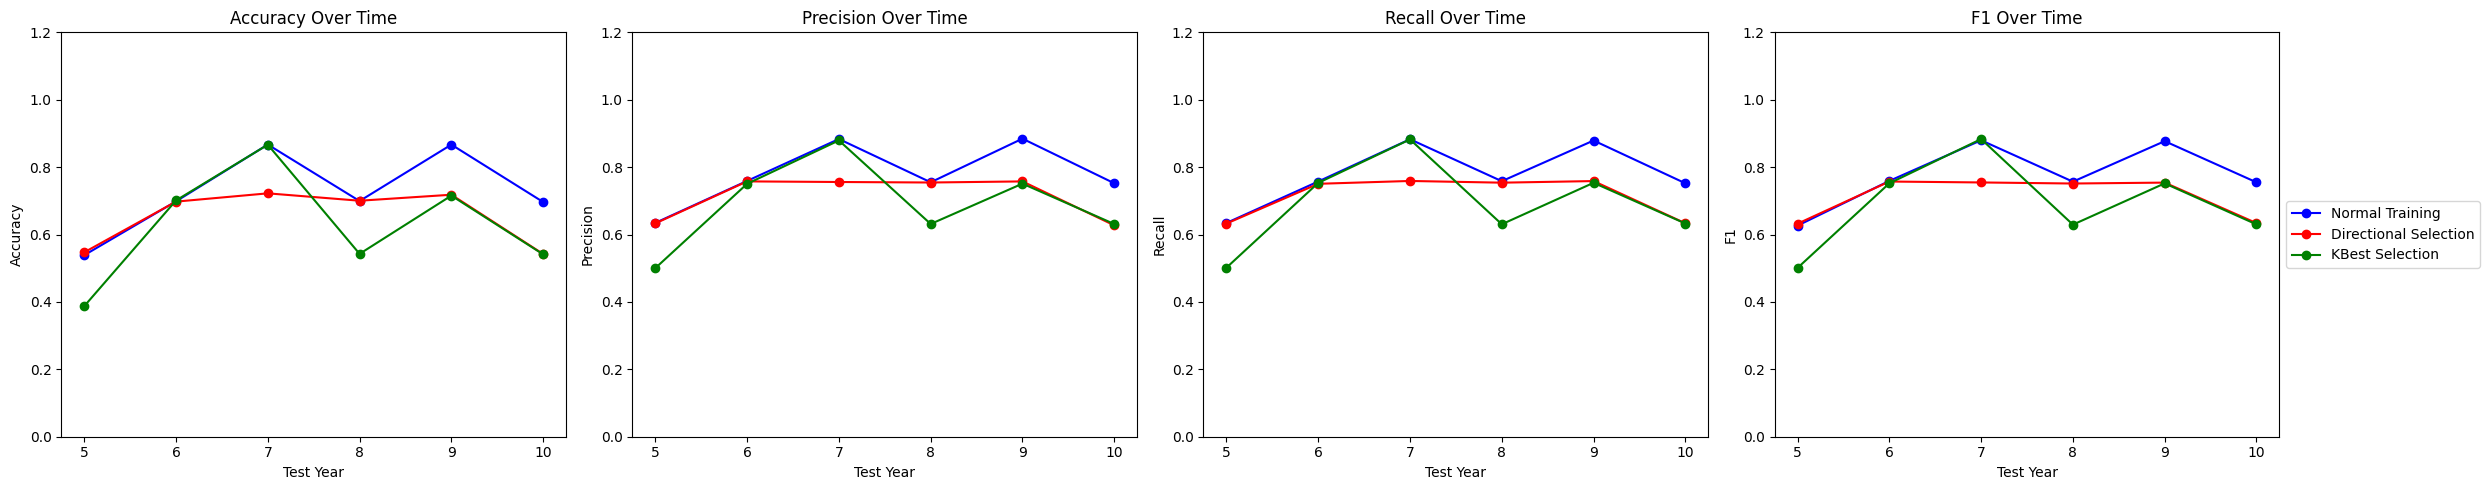

Normal Training
Accuracy:  0.7216117216117216
Precision:  0.7708333333333334
Recall:  0.7708333333333334
F1:  0.7708333333333334
10 year
Accuracy:  [0.5384615384615384, 0.6923076923076923, 0.8571428571428571, 0.6923076923076923, 0.8571428571428571]
Precision:  [0.625, 0.75, 0.875, 0.75, 0.875]
Recall:  [0.625, 0.75, 0.875, 0.75, 0.875]
F1:  [0.625, 0.75, 0.875, 0.75, 0.875]
Directional Selection
Accuracy:  0.6483516483516484
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.5384615384615384, 0.6923076923076923, 0.7142857142857143, 0.6923076923076923, 0.7142857142857143]
Precision:  [0.625, 0.75, 0.75, 0.75, 0.75]
Recall:  [0.625, 0.75, 0.75, 0.75, 0.75]
F1:  [0.625, 0.75, 0.75, 0.75, 0.75]
KBest Selection
Accuracy:  0.6208791208791208
Precision:  0.6875
Recall:  0.6875
F1:  0.6875
10 year
Accuracy:  [0.38461538461538464, 0.6923076923076923, 0.8571428571428571, 0.5384615384615384, 0.7142857142857143]
Precision:  [0.5, 0.75, 0.875, 0

In [ ]:
features = foward_selection(df_teams, MLPClassifier(), scaling=True)
print(features)
model = MLPClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest, scaling=True)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)


### lightgbm

#### Hyperparameter tuning

In [ ]:
# import lightgbm as lgb
# model = lgb.LGBMClassifier()
# param_grid = { 'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [5, 10, 15],
#     'num_leaves': [8, 16, 31, 63, 127],
#     'n_estimators': [50, 100, 200, 300],
#     'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
# }
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)
# LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=8) 0.8898461538461537


[LightGBM] [Info] Number of positive: 72, number of negative: 54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 126, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571429 -> initscore=0.287682
[LightGBM] [Info] Start training from score 0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

['year', 'tmID', 'rank', 'confW', 'confL', 'min', 'attend', 'num_playoff_appearances', 'mean_won', 'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostDQ', 'height', 'weight', 'award_count_x', 'won', 'lost', 'post_wins', 'award_count_y', 'performance', 'Postperformance', 'points_precision', 'Postpoints_precision', 'playoff']
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 12, number of negative: 11
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

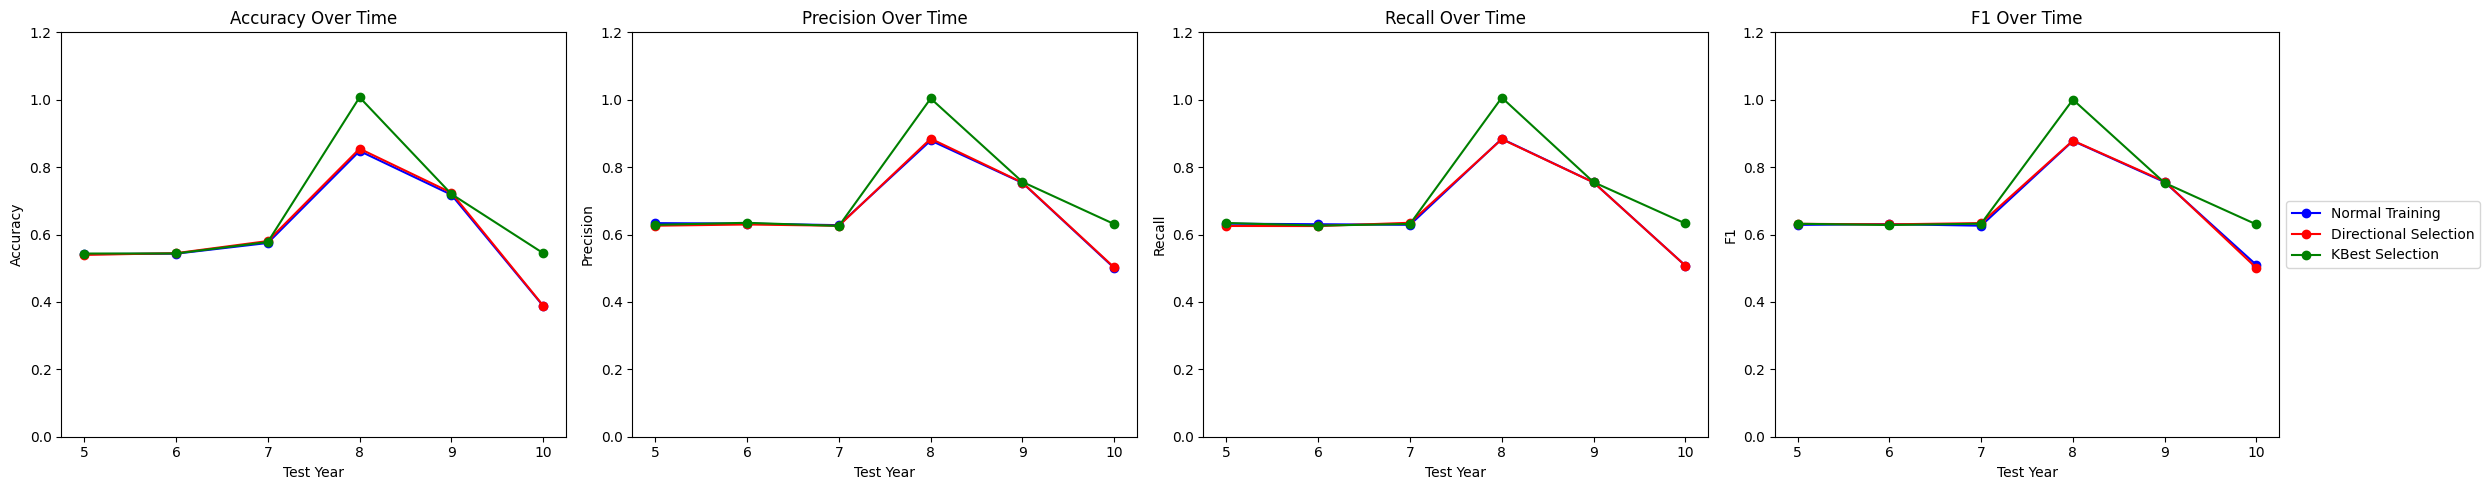

Normal Training
Accuracy:  0.5989010989010989
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1:  0.6666666666666666
10 year
Accuracy:  [0.5384615384615384, 0.5384615384615384, 0.5714285714285714, 0.8461538461538461, 0.7142857142857143]
Precision:  [0.625, 0.625, 0.625, 0.875, 0.75]
Recall:  [0.625, 0.625, 0.625, 0.875, 0.75]
F1:  [0.625, 0.625, 0.625, 0.875, 0.75]
Directional Selection
Accuracy:  0.5989010989010989
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1:  0.6666666666666666
10 year
Accuracy:  [0.5384615384615384, 0.5384615384615384, 0.5714285714285714, 0.8461538461538461, 0.7142857142857143]
Precision:  [0.625, 0.625, 0.625, 0.875, 0.75]
Recall:  [0.625, 0.625, 0.625, 0.875, 0.75]
F1:  [0.625, 0.625, 0.625, 0.875, 0.75]
KBest Selection
Accuracy:  0.6501831501831502
Precision:  0.7083333333333334
Recall:  0.7083333333333334
F1:  0.7083333333333334
10 year
Accuracy:  [0.5384615384615384, 0.5384615384615384, 0.5714285714285714, 1.0, 0.7142857142857143]


In [ ]:
import lightgbm as lgb
features = foward_selection(df_teams, lgb.LGBMClassifier())
print(features)
model = lgb.LGBMClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
years_tested, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
years_tested, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores = train_evaluate_decision_tree_graph(model, df_teams_kbest)
plot_metrics_over_time_three(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores, bidirectional_accuracy_scores, bidirectional_precision_scores, bidirectional_recall_scores, bidirectional_f1_scores, kbest_accuracy_scores, kbest_precision_scores, kbest_recall_scores, kbest_f1_scores)
